In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

import time

In [2]:
data_path_train = r"C:\Users\prana\Downloads\Covid19-dataset-20211122T042133Z-001\Covid19-dataset\train"
data_path_test = r"C:\Users\prana\Downloads\Covid19-dataset-20211122T042133Z-001\Covid19-dataset\test"

In [3]:
img_size = 120

In [4]:
img_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                          transforms.RandomHorizontalFlip(),transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])

In [5]:
train_data = ImageFolder(root = data_path_train, transform =img_transform)

In [6]:
testing_data = ImageFolder(root = data_path_test, transform = img_transform)

In [8]:
len(testing_data)


66

In [9]:
train_data.class_to_idx

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

In [10]:
test_data, val_data = random_split(testing_data,[16,50])

In [11]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

In [12]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([16, 3, 120, 120]) torch.Size([16])


In [13]:
def show_img_batch(data):
    for images, lables in data:
        plt.figure(figsize=(12,5))
        plt.imshow(make_grid(images, n_row=5).permute(1,2,0))
        plt.show()
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


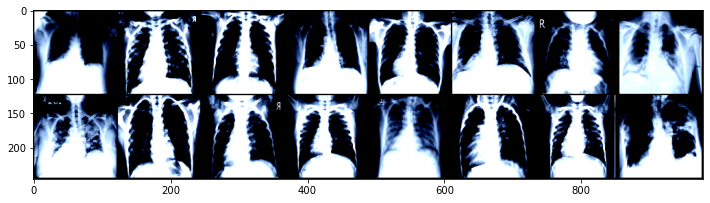

In [14]:
show_img_batch(train_loader)

In [15]:
class ANN(nn.Module):
    def __init__(self, hidden_layer1=64):
        super(ANN, self).__init__()
        
        self.hidden_layer1 = hidden_layer1
        
        self.fc1 = nn.Linear(img_size*img_size*3, hidden_layer1)
        self.fc2 = nn.Linear(hidden_layer1, 3)
        
        self.relu = nn.ReLU()
        
    def forward(self, img):

        out = img.view(-1, img_size*img_size*3)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)

        return out

In [16]:
model = ANN()
print(model.parameters)

<bound method Module.parameters of ANN(
  (fc1): Linear(in_features=43200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
)>


In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD( model.parameters(), lr= 0.001)

In [18]:
def ANN_train(loss_fn, optimizer):
    
    epochs=15
    
    training_loss =[]
    training_acc =[]
    testing_loss = []
    testing_acc =[]
    
    for epoch in range(epochs):
        
        train_acc = 0.0
        train_loss = 0.0
        
        model.train()
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            
            loss.backward()
            optimizer.step()
            
            predictions = torch.argmax(output, 1)
            
            train_acc += (predictions == labels).sum().item()
            train_loss += loss.item()
            
        training_acc.append(train_acc/len(train_data))
        training_loss.append(train_loss/len(train_loader))
        
        test_acc = 0.0
        test_loss = 0.0
        
        with torch.no_grad():
            
            for images, labels in val_loader:
                output = model(images)
                loss = loss_fn(output,labels)
                
                predictions = torch.argmax(output,1)
                
                test_acc += (predictions == labels).sum().item()
                test_loss += loss.item()
                
            testing_acc.append(test_acc/len(val_data))
            testing_loss.append(test_loss/len(val_loader))
            
            print("Epochs:{}, Training Accuracy:{:.2f}, Training Loss:{:.2f}, Validation Accuracy:{:2f}, Validation Loss:{:.2f}".format(
            epoch+1,train_acc/len(train_data),train_loss/len(train_loader),test_acc/len(val_data),test_loss/len(val_loader)))
                
            
    plt.title("Accuracy Vs Epochs")
    plt.plot(range(epochs), training_acc, label ="Training Accuracy")
    plt.plot(range(epochs), testing_acc, label = "Validation Accuracy")
    plt.legend()
    plt.xlabel("Accuracy")
    plt.ylabel("Epochs")
    plt.show()
    
    plt.title("Loss Vs Epochs")
    plt.plot(range(epochs), training_loss, label ="Training Loss")
    plt.plot(range(epochs), testing_loss, label = "Validation Loss")
    plt.legend()
    plt.xlabel("Accuracy")
    plt.ylabel("Epochs")
    plt.show()
            

Epochs:1, Training Accuracy:0.80, Training Loss:0.58, Validation Accuracy:0.760000, Validation Loss:0.57
Epochs:2, Training Accuracy:0.86, Training Loss:0.38, Validation Accuracy:0.800000, Validation Loss:0.86
Epochs:3, Training Accuracy:0.89, Training Loss:0.29, Validation Accuracy:0.840000, Validation Loss:0.69
Epochs:4, Training Accuracy:0.88, Training Loss:0.26, Validation Accuracy:0.740000, Validation Loss:0.69
Epochs:5, Training Accuracy:0.94, Training Loss:0.23, Validation Accuracy:0.800000, Validation Loss:0.67
Epochs:6, Training Accuracy:0.93, Training Loss:0.21, Validation Accuracy:0.900000, Validation Loss:0.48
Epochs:7, Training Accuracy:0.95, Training Loss:0.18, Validation Accuracy:0.820000, Validation Loss:0.75
Epochs:8, Training Accuracy:0.95, Training Loss:0.18, Validation Accuracy:0.920000, Validation Loss:0.53
Epochs:9, Training Accuracy:0.95, Training Loss:0.15, Validation Accuracy:0.900000, Validation Loss:0.55
Epochs:10, Training Accuracy:0.95, Training Loss:0.15, 

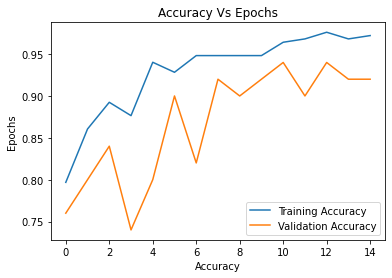

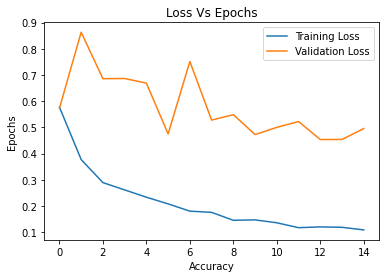

In [19]:
ANN_train(loss_fn, optimizer)

In [23]:
def predict_image( img, model):
    x = img.unsqueeze(0)
    y = model(x)
    
    pred = torch.argmax(y, dim=1)
    
    return testing_data.classes[pred]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label: Normal Predicted Label: Normal


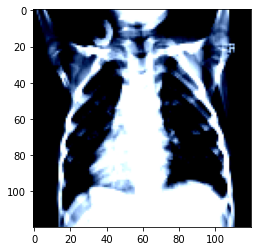

In [24]:
img, label = test_data[2]
plt.imshow(img.permute(1,2,0))
print("Actual Label:", testing_data.classes[label], "Predicted Label:", predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label: Covid Predicted Label: Covid


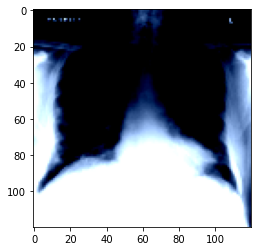

In [25]:
img, label = test_data[6]
plt.imshow(img.permute(1,2,0))
print("Actual Label:", testing_data.classes[label], "Predicted Label:", predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label: Covid Predicted Label: Covid


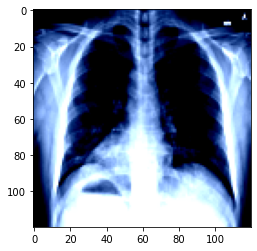

In [26]:
img, label = test_data[8]
plt.imshow(img.permute(1,2,0))
print("Actual Label:", testing_data.classes[label], "Predicted Label:", predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label: Viral Pneumonia Predicted Label: Viral Pneumonia


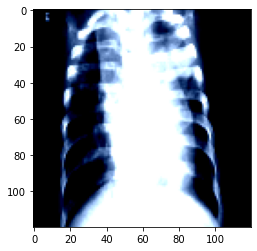

In [27]:
img, label = test_data[1]
plt.imshow(img.permute(1,2,0))
print("Actual Label:", testing_data.classes[label], "Predicted Label:", predict_image(img, model))